In [1]:
library(survival)
library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**1.** The following table gives a small data set of survival times and a covariate $z$:

| Patient ID (Gender) | Survival time in years | z |
| --- | --- | --- |
| 1 (M) | 4 | 2 |
| 2 (M) | 4+ | 2 |
| 3 (M) | 5 | 1 |
| 4 (M) | 6 | 3 |
| 5 (F) | 7 | 4 |
| 6 (F) | 8 | 3 |
| 7 (F) | 9+ | 5 |

where $+$ means a right censored observation. Assuming a Cox proportional hazards model:

In [2]:
data = data.frame(
    male = c(1, 1, 1, 1, 0, 0, 0),
    time = c(4, 4, 5, 6, 7, 8, 9),
    status = c(1, 0, 1, 1, 1, 1, 0),
    z = c(2, 2, 1, 3, 4, 3, 5)
)

data

male,time,status,z
<dbl>,<dbl>,<dbl>,<dbl>
1,4,1,2
1,4,0,2
1,5,1,1
1,6,1,3
0,7,1,4
0,8,1,3
0,9,0,5


$$\lambda(t|z) = \lambda_0(t) e^{\beta z},$$

do the following:
1. **Stratified $\lambda_0(t)$ by gender (which is unique for Cox model only), write down the partial likelihood function for $\beta$, and find its MLE, standard error and p-value.**

$$
\lambda = 
\left(
    {\exp(2\beta) \over \exp(2\beta)+ \exp(2\beta) + \exp(1\beta) + \exp(3\beta)}\\
    {\exp(1\beta) \over \exp(1\beta) + \exp(3\beta)}
\right)\\
\left(
{\exp(4\beta) \over \exp(4\beta)+ \exp(3\beta) + \exp(5\beta)}\\
{\exp(3\beta) \over \exp(3\beta) + \exp(5\beta)}
\right)
$$

In [3]:
L_sym = expression(
    log(
        (exp(2*beta) / (exp(2*beta) + exp(2*beta) + exp(1*beta) + exp(3*beta))) *
        (exp(1*beta) / (exp(1*beta) + exp(3*beta))) *
        (exp(4*beta) / (exp(4*beta) + exp(3*beta) + exp(5*beta))) *
        (exp(3*beta) / (exp(3*beta) + exp(5*beta)))
    )
)

dL_sym = D(L_sym, "beta")
ddL_sym = D(dL_sym, "beta")

dL = function(beta) {
    eval(dL_sym, list(beta = beta))
}

ddL = function(beta) {
    eval(ddL_sym, list(beta = beta))
}

# solve for when derivative is zero
beta_hat = uniroot(dL, c(-10, 10))$root

# get observed fisher information
beta_fi = ddL(beta = beta_hat)

# fit parameter value
beta_hat
#standard error
se = sqrt(-1/beta_fi)
# confidence interval
c(
    beta_hat + (1.96 * se),
    beta_hat - (1.96 * se)
)
# p-value
2*(1 - pnorm(abs(beta_hat/se)))

[1] -0.7101752

[1]  0.6050812 -2.0254315

[1] 0.2899161

This is our estimate of beta, 95% confidence interval, and a p-value.

2. **Redo (a), using coxph in R (or using SAS) to double-check your result in (a).**

In [4]:
m0 = coxph(Surv(time, status) ~ z + strata(male), data = data)
m0
confint(m0)

Call:
coxph(formula = Surv(time, status) ~ z + strata(male), data = data)

     coef exp(coef) se(coef)      z    p
z -0.7102    0.4916   0.6710 -1.058 0.29

Likelihood ratio test=1.34  on 1 df, p=0.2476
n= 7, number of events= 5 

,2.5 %,97.5 %
z,-2.025399,0.6050591


We have succesfully replicated our earlier results.

**2.** Using the Male Laryngeal Cancer data set (`larynx.csv`, in Week 14 folder), fit Cox proportional hazard models and perform regression diagnostics. If there is an issue/problem from the diagnostics assessment, consider an alternative functional form for this continuous variable or consider stratification for this categorical variable (factor).

This data frame contains the following columns:
- `stage`: Stage of disease (1=stage 1, 2=stage2, 3=stage 3, 4=stage 4)
- `time`: Time to death or on-study time, months
- `age`: Age at diagnosis of larynx cancer
- `diagyr`: Year of diagnosis of larynx cancer
- `delta`: Death indicator (0=alive, 1=dead)

In [5]:
lar = read.csv("larynx.csv") %>%
    mutate(stage = factor(stage, levels = as.character(seq(1, 4))))
head(lar)

,patients,stage,time,age,diagyr,delta
,<int>,<fct>,<dbl>,<int>,<int>,<int>
1,1,1,0.6,77,76,1
2,2,1,1.3,53,71,1
3,3,1,2.4,45,71,1
4,4,1,2.5,57,78,0
5,5,1,3.2,58,74,1
6,6,1,3.2,51,77,0


Do the following:
1. **What is the median follow-up of this study?**


In [6]:
survfit(Surv(time, 1 - delta) ~ 1, data = lar)

Call: survfit(formula = Surv(time, 1 - delta) ~ 1, data = lar)

      n events median 0.95LCL 0.95UCL
[1,] 90     40    6.5     5.5     7.6

The median follow up time is 6.5 (95% CI: [5.5, 7.6])

2. **A Cox model with the factor stage was considered (treat stage as a factor, not a continuous variable). Determine if adding age into the model is appropriate using a martingale residual plot. If age should not enter the model as linear term, suggest a functional form for age.**


In [7]:
head(lar)

,patients,stage,time,age,diagyr,delta
,<int>,<fct>,<dbl>,<int>,<int>,<int>
1,1,1,0.6,77,76,1
2,2,1,1.3,53,71,1
3,3,1,2.4,45,71,1
4,4,1,2.5,57,78,0
5,5,1,3.2,58,74,1
6,6,1,3.2,51,77,0


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


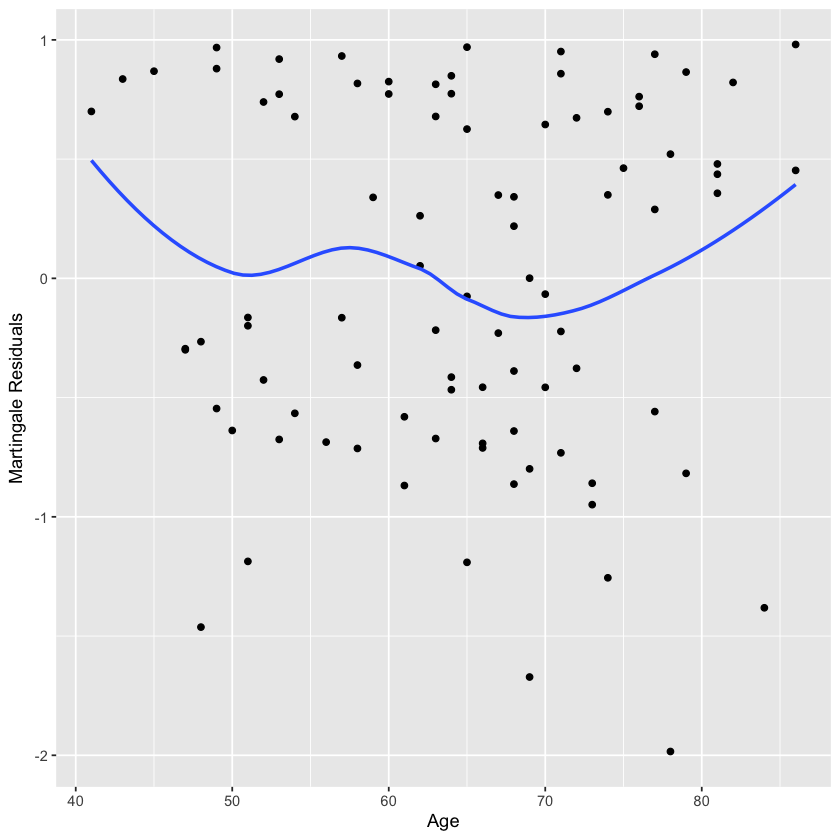

In [8]:
m1 = coxph(Surv(time, delta) ~ stage + age, data = lar)

lar %>%
    mutate(mres = residuals(m1, type="martingale")) %>%
    ggplot(aes(x = age, y = mres)) +
    geom_point() +
    geom_smooth(se = FALSE) +
    labs(x = "Age", y = "Martingale Residuals")

This does not looke great. We should be getting a flat line, but the curvyness suggests that age is not a linear term.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


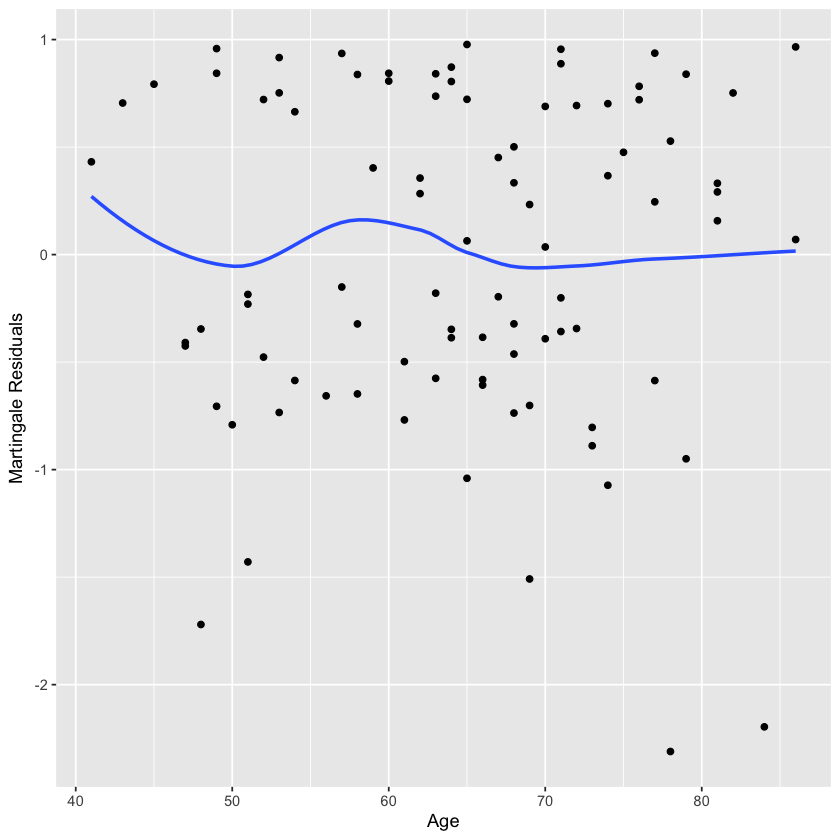

In [9]:
lar = lar %>%
    mutate(age2 = age^2)

m2 = coxph(Surv(time, delta) ~ stage + age + age2, data = lar)

lar %>%
    mutate(mres = residuals(m2, type="martingale")) %>%
    ggplot(aes(x = age, y = mres)) +
    geom_point() +
    geom_smooth(se = FALSE) +
    labs(x = "Age", y = "Martingale Residuals")

This is a lot less curvy, so it looks like a quadratic term is appropriate.

3. **Repeat part (b) for the covariate year of diagnosis of larynx cancer.**


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


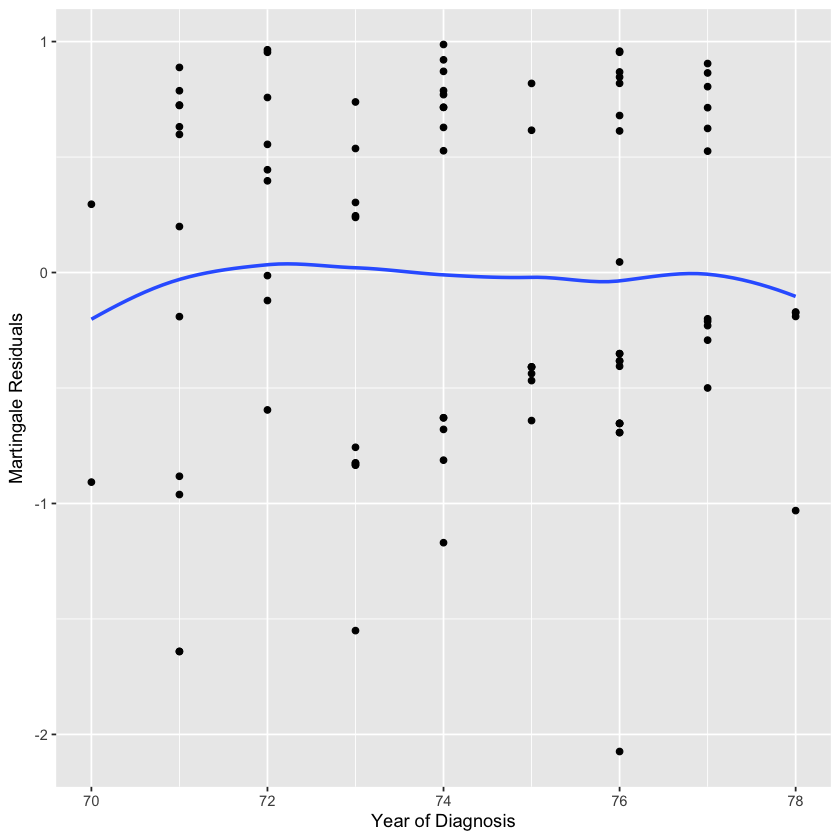

In [10]:
m3 = coxph(Surv(time, delta) ~ stage + diagyr, data = lar)

lar %>%
    mutate(mres = residuals(m3, type="martingale")) %>%
    ggplot(aes(x = diagyr, y = mres)) +
    geom_point() +
    geom_smooth(se = FALSE) +
    labs(x = "Year of Diagnosis", y = "Martingale Residuals")

4. **Fit a Cox model with the factor stage of disease and a linear term for age. Perform a general examine of this model using Cox-Snell residual (Bonus question below).**


In [11]:
m4 = coxph(Surv(time, delta) ~ stage + age, data = lar)

m4_res = lar %>%
    mutate(
        mres = residuals(m4, type="martingale"),
        csres = delta - mres
    )

m4_sf = survfit(Surv(csres, delta) ~ 1, data = m4_res, type="fleming-harrington")

m4_sf

Call: survfit(formula = Surv(csres, delta) ~ 1, data = m4_res, type = "fleming-harrington")

      n events median 0.95LCL 0.95UCL
[1,] 90     50   0.66   0.547    1.07

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


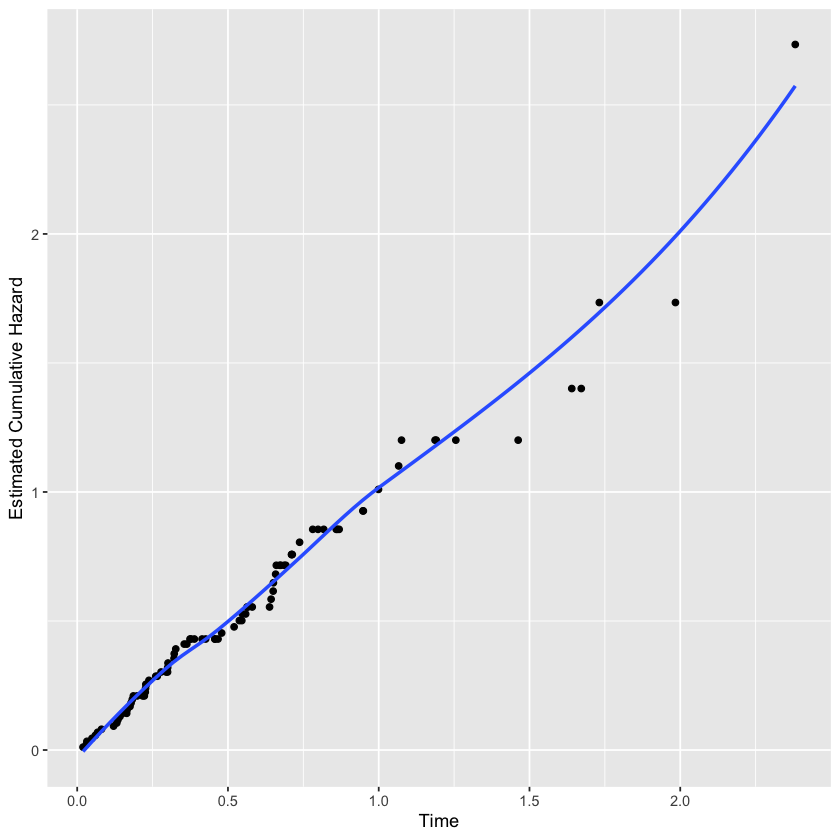

In [12]:
data.frame(time = m4_sf$time, surv = -log(m4_sf$surv)) %>%
    ggplot(aes(x = time, y = surv)) +
    geom_point() +
    geom_smooth(se = FALSE) +
    labs(x = "Time", y = "Estimated Cumulative Hazard")

This looks good.

5. **Fit a Cox model with a dichotomized stage of disease (high if stage = 3 or 4, low if stage = 1 or 2) and a linear term for age. Use `cox.zph` (R code) to examine the proportional hazard assumption for the dichotomized stage. If the proportional hazard assumption is violated, refit the model with stratification on the dichotomized stage.**

In [13]:
lar = lar %>%
    mutate(stage_high = ifelse(stage == 3 | stage == 4, 1, 0))

m5 = coxph(Surv(time, delta) ~ stage_high + age, data = lar)
cox.zph(m5)

           chisq df     p
stage_high 5.181  1 0.023
age        0.705  1 0.401
GLOBAL     6.227  2 0.044

This is not great. Both global and stage_high tests are significant, suggesting a violation of the proportional hazard assumption. Let's rerun with stratification.

In [14]:
m6 = coxph(Surv(time, delta) ~ strata(stage_high) + age, data = lar)
cox.zph(m6)

       chisq df    p
age    0.862  1 0.35
GLOBAL 0.862  1 0.35

This is much happier. We don't have a violation that's statistically significant.